# Example 1 - Single Point

In [1]:
import Pkg; Pkg.activate("../")
using Kelp, Plots, Interpolations;pyplot();

┌ Info: Precompiling Kelp [7cd05660-c499-409f-9aa8-d8700f4bb051]
└ @ Base loading.jl:1317


Set initial conditions and parameters
- t_i - start day (days since January first) - needs to have the same date reference as the forcing data
- nd - number of days to run for
- lat - latitude as this effects the change in day length
- a_0,n_0,c_0 - initial area, nitrogen reserve and carbon reserve

In [5]:
t_i = 1.0;nd = 600;lat = 60
a_0 = 0.1;n_0 = 0.022;c_0 = 0.3;

Setting the forcing variables, these would normally be loaded from a data set but here will be generated
- time - day corresponding to forcing data in days since January first (year is arbitrary). This **must** be a float rather than an integer or ODE solving library fails
- temp - temperature in degrees C
- no3 - nitrate concentration in mmol/m³
- irr - PAR irradiance in mol photons/m²/day
- u - water velocity in m/s

In [6]:
time = [1:2:800;]

temp = 6 * cos.((time .- 250) .* 2 .* pi ./ 365) .+ 8
no3 = (7 .* ((cos.(time .* 2 .* pi ./ 365) .+ 1) ./ 2).^3 .+ 0.1) ./ 1000
irr = 40 .* (sin.((time .+ 15) .* pi ./ 365).^10) .+ 1
u = repeat([0.15],length(time));

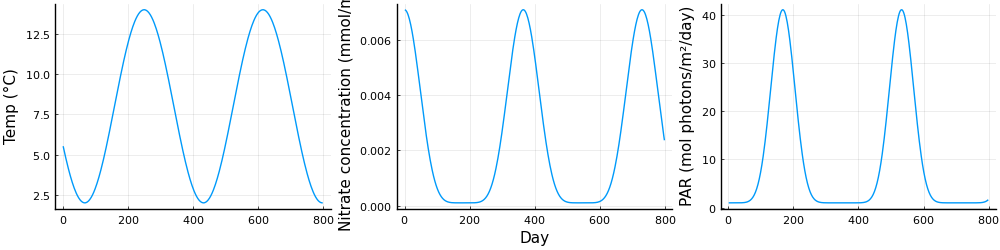

In [7]:
plot(layout=grid(1,3),size=(1000,250),legend=false)
plot!(time,temp,ylabel="Temp (°C)",sp=1)
plot!(time,no3,xlabel="Day",ylabel="Nitrate concentration (mmol/m³)",sp=2)
plot!(time,irr,ylabel="PAR (mol photons/m²/day)",sp=3)

The forcing variables must be converted to interpolations for the kelp model to access them at arbitrary time

In [16]:
temp_itp=Interpolations.LinearInterpolation(time,temp)
no3_itp=Interpolations.LinearInterpolation(time,no3)
irr_itp=Interpolations.LinearInterpolation(time,irr)
u_itp=Interpolations.LinearInterpolation(time,u);

Now the model can be run, the parameter file must be passed and in this run the respiration model proposed in Broch, 2013 is being used

In [17]:
solution, results = Kelp.solvekelp(t_i, nd, u_itp, temp_itp, irr_itp, no3_itp, lat, a_0, n_0, c_0, "../src/parameters/2013.jl",2);

Solutions contains the raw output of the ODE solver while results is refactored into a dataframe (this can optionally be turned off for an array to be returned)

In [7]:
results

,area,nitrogen,carbon,gross_nitrate,time
,Any,Any,Any,Any,Any
1,0.1,0.022,0.3,0.0,1.0
2,0.109134,0.0189379,0.267903,8.52351e-8,2.0
3,0.116672,0.0167756,0.247928,3.68739e-7,3.0
4,0.122468,0.0152978,0.237388,8.09489e-7,4.0
5,0.126655,0.014318,0.23388,1.36651e-6,5.0
6,0.129536,0.0136848,0.235377,2.00431e-6,6.0
7,0.131451,0.0132832,0.240287,2.69541e-6,7.0
8,0.132698,0.0130318,0.247446,3.42009e-6,8.0
9,0.133506,0.0128758,0.256043,4.16497e-6,9.0


It is useful to convert the results into total carbon and nitrogen masses (rather than the reserves that the model returns), this requires some of the parameters.

In [18]:
include("../src/parameters/2013.jl")
total_carbon = results.area .* K_A .* (results.carbon .+ C_struct)
total_nitrogen = results.area .* K_A .* (results.nitrogen .+ N_struct);

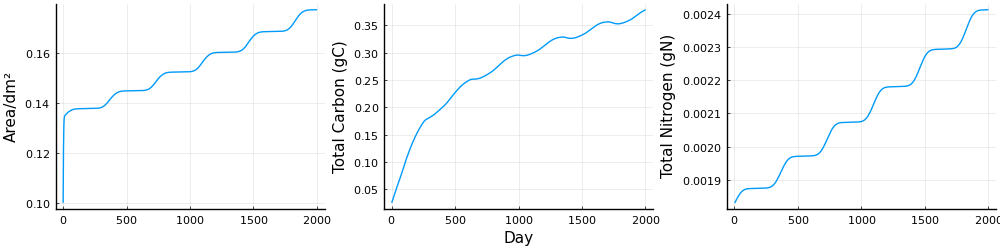

In [19]:
plot(layout=grid(1,3),size=(1000,250),legend=false)
plot!(results.time,results.area,ylabel="Area/dm²",sp=1)
plot!(results.time,total_carbon,xlabel="Day",ylabel="Total Carbon (gC)",sp=2)
plot!(results.time,total_nitrogen,ylabel="Total Nitrogen (gN)",sp=3)

# Example 2 - Grid

For a grid we must set initial conditions as with a single point

In [10]:
t_i = 1.0;nd = 300
a_0 = 0.1;n_0 = 0.022;c_0 = 0.3;

This time we will generate a 4d grid of input data for temp and no3 and 2d for nitrate. An additional variable needs to be generated, either a 3d diffuse attenuation coefficient or 4d light attenuation. In this example the latter is used. Again this would usually be loaded from a file. It is beneficial to define all of these as constants as it drastically speeds up on larger grids.

In [11]:
const arr_lon=[45:50;]
const arr_lat=[55:65;]
const arr_dep=[0:5:75;]
const arr_t = [0:2:310;]

const arr_temp = permutedims(repeat(6 * cos.((arr_t .- 250) .* 2 .* pi ./ 365) .+ 8,1,length(arr_lon),length(arr_lat),length(arr_dep)),(2,3,4,1)).*permutedims(repeat(arr_lat./arr_lat[1],1,length(arr_lon),length(arr_dep),length(arr_t)),(2,1,3,4))
const arr_no3 = permutedims(repeat((7 .* ((cos.(arr_t .* 2 .* pi ./ 365) .+ 1) ./ 2).^3 .+ 0.1) ./ 1000,1,length(arr_lon),length(arr_lat),length(arr_dep)),(2,3,4,1)).*repeat(arr_lon./arr_lon[1],1,length(arr_lat),length(arr_dep),length(arr_t))
const arr_irr = permutedims(repeat(40 .* (sin.((arr_t .+ 15) .* pi ./ 365).^10) .+ 1,1,length(arr_lon),length(arr_lat)),(2,3,1)).*permutedims(repeat(arr_lat./arr_lat[1],1,length(arr_lon),length(arr_t)),(2,1,3))
const arr_beta = permutedims(repeat(reverse([0:1/(length(arr_dep)-1):1;]),1,length(arr_lon),length(arr_lat),length(arr_t)),(2,3,1,4))
const arr_u = permutedims(repeat([0.15],length(arr_t),length(arr_lon),length(arr_lat),length(arr_dep)),(2,3,4,1));

These grids are directly fed to the grid solver, which returns an array. irr can have its own time provided as satellite products often do not have the same temporal resolution as models. Additionally, a fill value, in this case NaN, can be provided as they are often temporally sparse and need to be filtered.

This function automatically parallelises to however many threads you start julia with

In [ ]:
@time results = Kelp.solvegrid(t_i, nd, a_0, n_0, c_0, arr_lon, arr_lat, arr_dep, arr_t, arr_no3, arr_temp, arr_u, (arr_irr, arr_t, NaN), (nothing, nothing, nothing), arr_beta, "../src/parameters/2013.jl", 2);

┌ Info: At level 1
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 2
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 3
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 4
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 5
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 6
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 7
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 8
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 9
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 10
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 11
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At level 12
└ @ Kelp /home/jago/Documents/Projects/Kelp.jl/src/Kelp.jl:337
┌ Info: At le

The output from this is an array with area/nitrogen reserve/carbon reserve/nitrate uptake in the first dimension, then lon,lat,dep,time in the others. We can extract the total carbon and nitrogen again:

In [ ]:
total_carbon = results[1,:,:,:,:] .* K_A .* (results[3,:,:,:,:] .+ C_struct)
total_nitrogen = results[1,:,:,:,:] .* K_A .* (results[2,:,:,:,:] .+ N_struct);

We could plot these for a couple of points as a comparison for above:

In [ ]:
plot(layout=grid(1,3),size=(1000,300))
results_time=[0:nd;]
for r=1:10
    i,j,k=rand([1:length(arr_lon);]),rand([1:length(arr_lat);]),rand([1:length(arr_dep);])
    plot!(results_time,results[1,i,j,k,:],sp=1,label="$(arr_lat[j])N, $(arr_lon[i])W, $(arr_dep[k])m")
    plot!(results_time,total_carbon[i,j,k,:],sp=2)
    plot!(results_time,total_nitrogen[i,j,k,:],sp=3)
end
plot!(ylabel="Area/dm²",sp=1,legend=:bottomright);plot!(sp=2,xlabel="Day",ylabel="Total Carbon (gC)",legend=false);plot!(sp=3,ylabel="Total Nitrogen (gN)",legend=false)

Or we could plot a heatmap of the surfaces:

In [ ]:
hms=[
    heatmap(arr_lon,arr_lat,total_carbon[:,:,1,end]',color=cgrad(:bamako, rev=true),colorbar_title="Total Carbon (gC)"),
    heatmap(arr_lon,arr_lat,total_nitrogen[:,:,1,end]',color=:lajolla,colorbar_title="Total Nitrogen (gN)"),
    heatmap(arr_lon,arr_lat,total_carbon[:,:,1,end]'./total_nitrogen[:,:,1,end]',color=cgrad(:lapaz, rev=true),colorbar_title="Carbon:Nitrogen ratio")
]
plot!(hms...,layout=grid(1,3),size=(1000,200))